In [ ]:
instance_idx = 1

In [1]:
!gdown "https://drive.google.com/uc?id=#####################################"

Downloading...
From: https://drive.google.com/uc?id=#####################################
To: /content/uc?id=#####################################
1.70kB [00:00, 3.26MB/s]


In [ ]:
!unzip /content/vox_frames.zip

Streaming output truncated to the last 5000 lines.
  inflating: vox_frames/G0cGX1w27Ao#00163#4464-4779_cropped_fr_138.png  
  inflating: vox_frames/LpDCe--Jl0I#00106#1086-1281_cropped_fr_84.png  
  inflating: vox_frames/Aa3hzVModBs#00108#1572-1737_cropped_fr_130.png  
  inflating: vox_frames/hdGOc69AfpM#00073#1690-1791_cropped_fr_50.png  
  inflating: vox_frames/c9DkAD4nIx0#00197#1154-1724_cropped_fr_439.png  
  inflating: vox_frames/M_qI7PnKxXg#00016#3451-3598_cropped_fr_140.png  
  inflating: vox_frames/kJPT6XIqQoI#00074#2790-3185_cropped_fr_248.png  
  inflating: vox_frames/XA4gLn6wixU#00083#10022-10186_cropped_fr_39.png  
  inflating: vox_frames/rdl1ydlf2GA#00065#4868-5237_cropped_fr_52.png  
  inflating: vox_frames/9ghrFg9-Tz8#00070#10393-10849_cropped_fr_341.png  
  inflating: vox_frames/Ai0IW59I5G0#00037#1945-2144_cropped_fr_8.png  
  inflating: vox_frames/J7UQB86XYYA#00023#1115-1284_cropped_fr_50.png  
  inflating: vox_frames/D0bsvqHkbKA#00087#3051-3266_cropped_fr_47.png  
  in

In [ ]:
import os
def split_indices(length, n):
    # Calculate the approximate size of each chunk
    chunk_size = length // n
    remainder = length % n

    # Generate indices
    indices = []
    start = 0
    for i in range(n):
        # Distribute the remainder elements among the first 'remainder' chunks
        end = start + chunk_size + (1 if i < remainder else 0)
        indices.append((start, end ))  # Lower and upper index
        start = end

    return indices

# Example usage
length_of_list = len(os.listdir("/content/vox_frames"))
n = 16
bounds = split_indices(length_of_list, n)
lower_idx = bounds[instance_idx-1][0]
upper_idx = bounds[instance_idx-1][1]

def adjust_indices(lower_idx, upper_idx, batch_size=1000):

    current_size = upper_idx - lower_idx
    adjustment = current_size % batch_size  # Difference to match batch size
    # Adjust indices proportionally
    new_lower_idx = lower_idx
    new_upper_idx = upper_idx + batch_size -  adjustment        # Ensure proportional range

    return new_lower_idx, new_upper_idx

# Adjust indices
lower_idx, upper_idx = adjust_indices(lower_idx, upper_idx, batch_size=1000)
print(lower_idx, upper_idx)


0 72000


Calculating Mean: 72it [00:19,  3.74it/s]
Fitting PCA: 72it [1:01:24, 51.18s/it]


Incremental PCA model and mean image saved.
Incremental PCA model and mean image loaded.


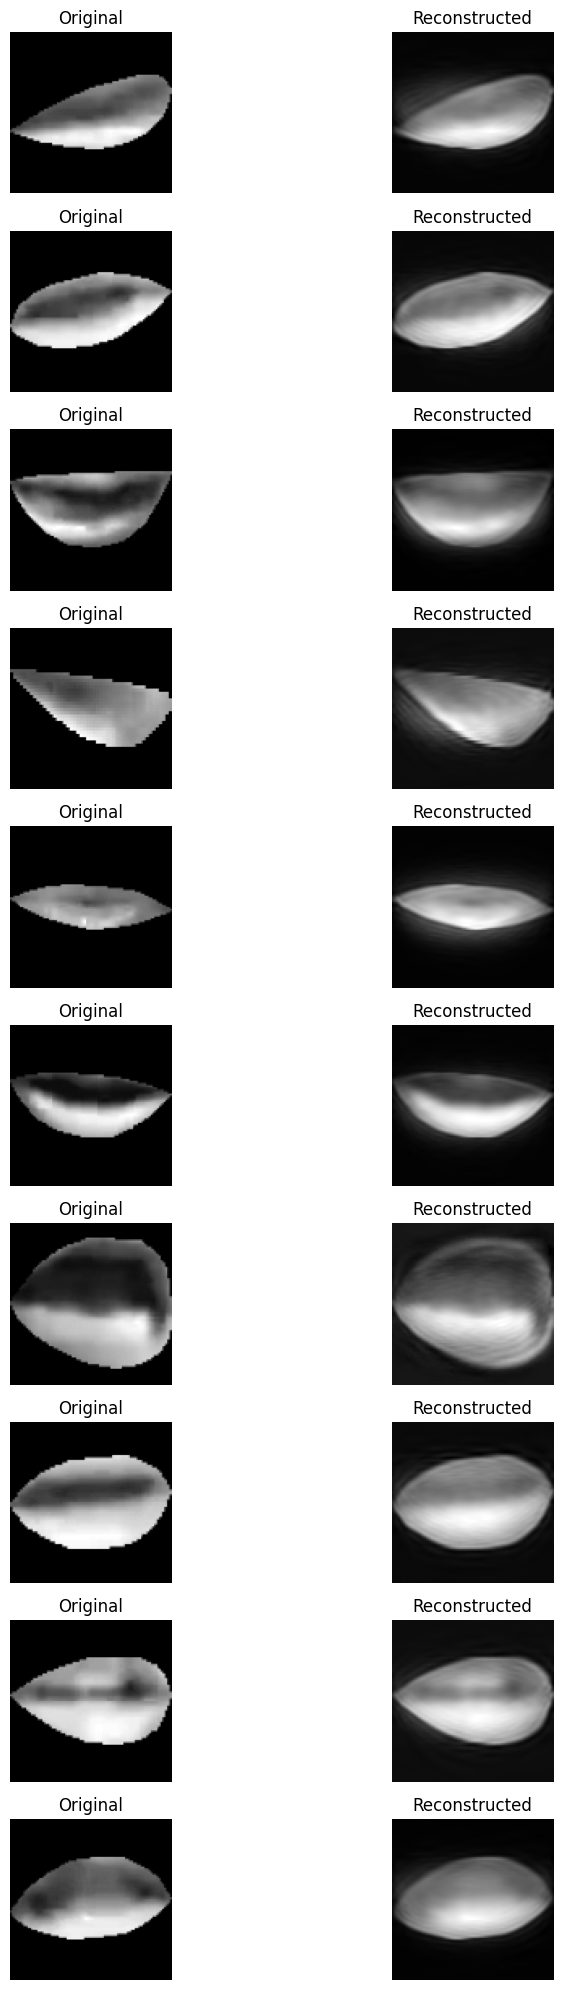

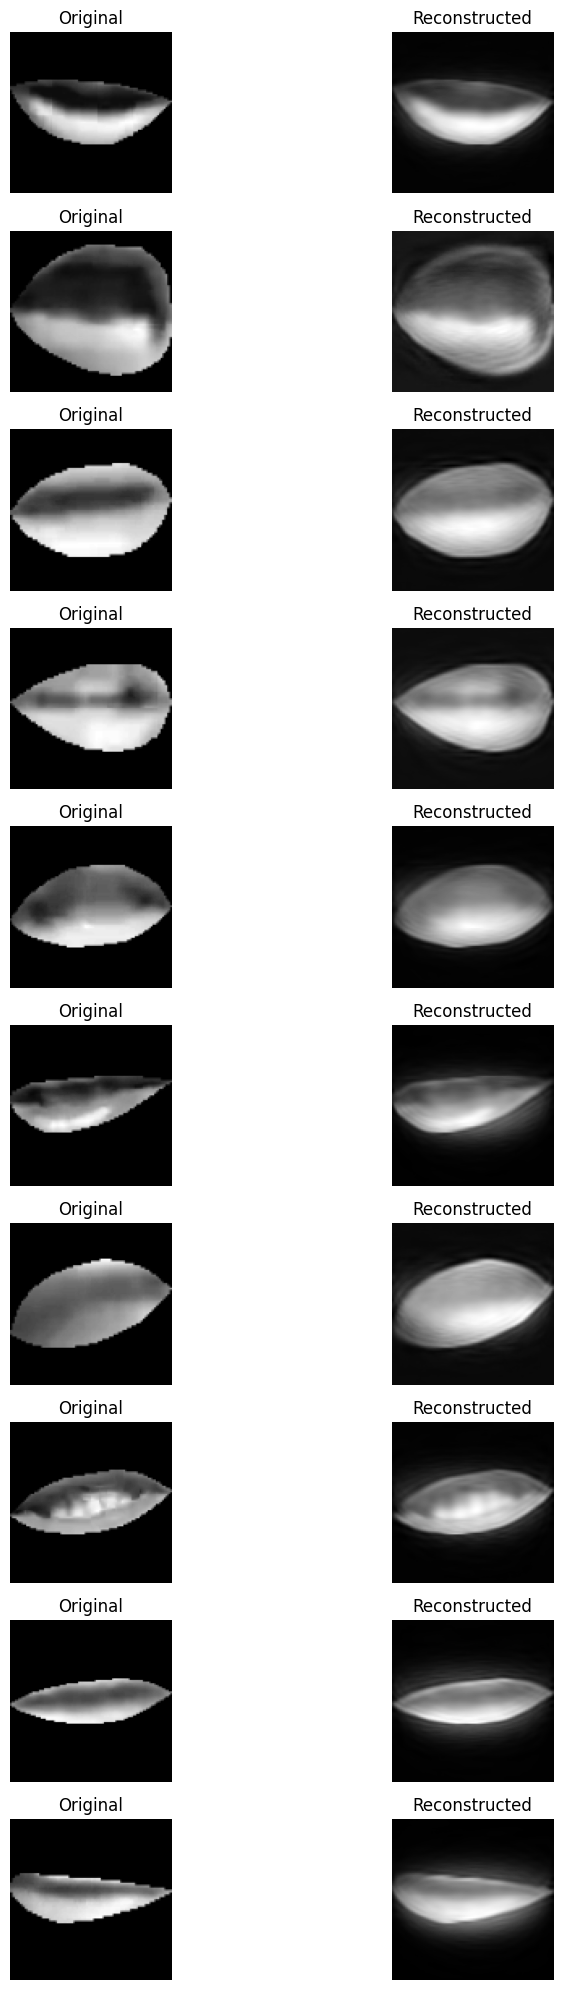

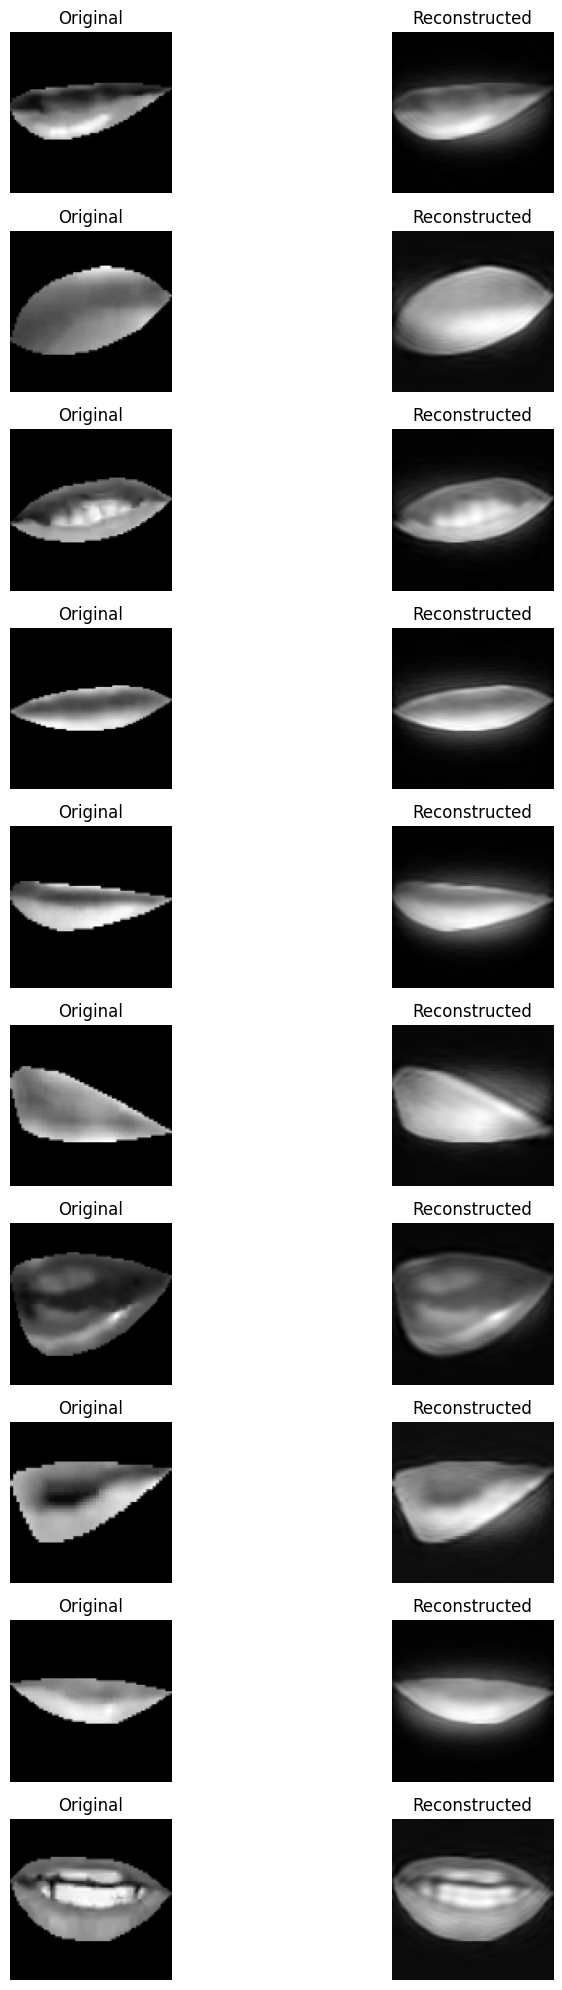

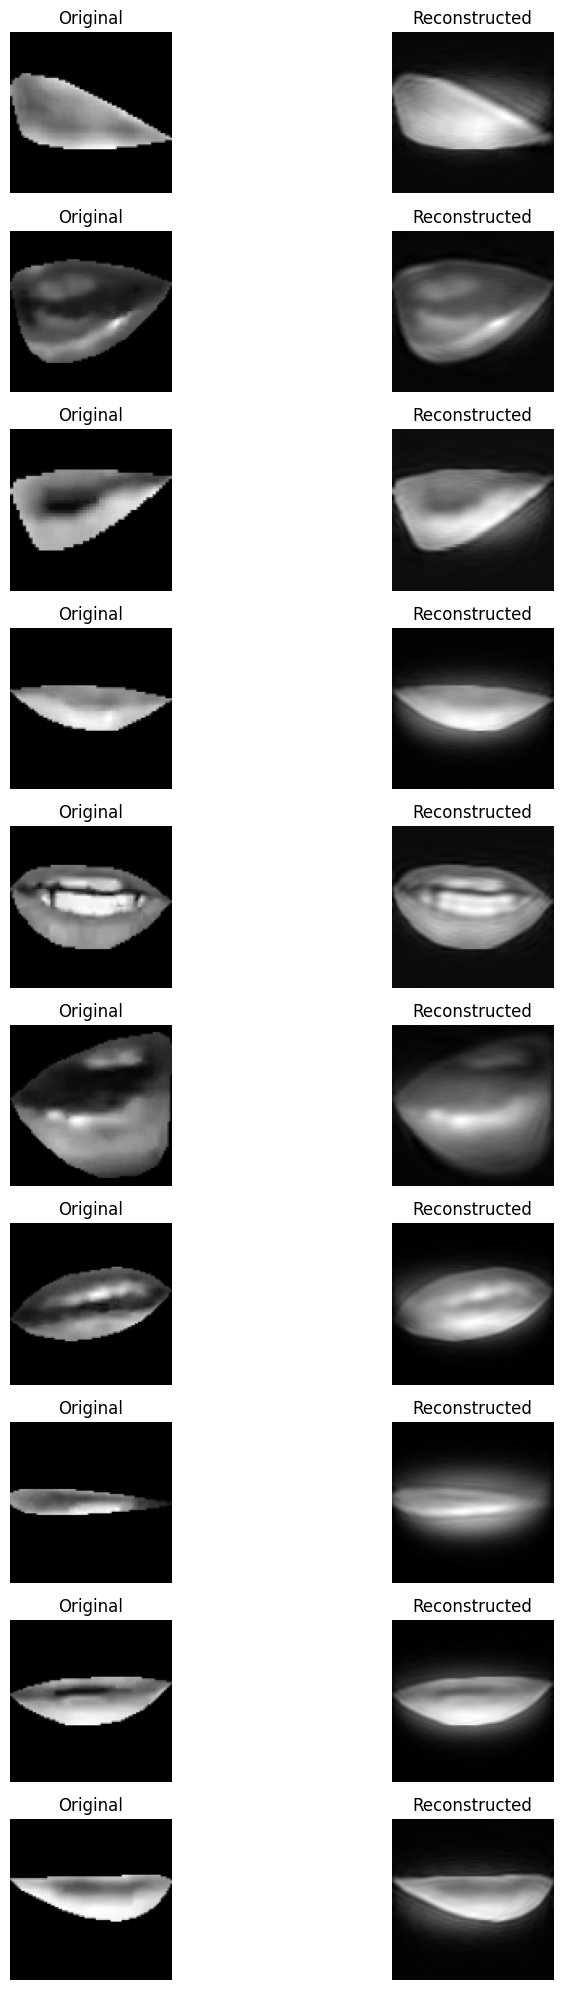

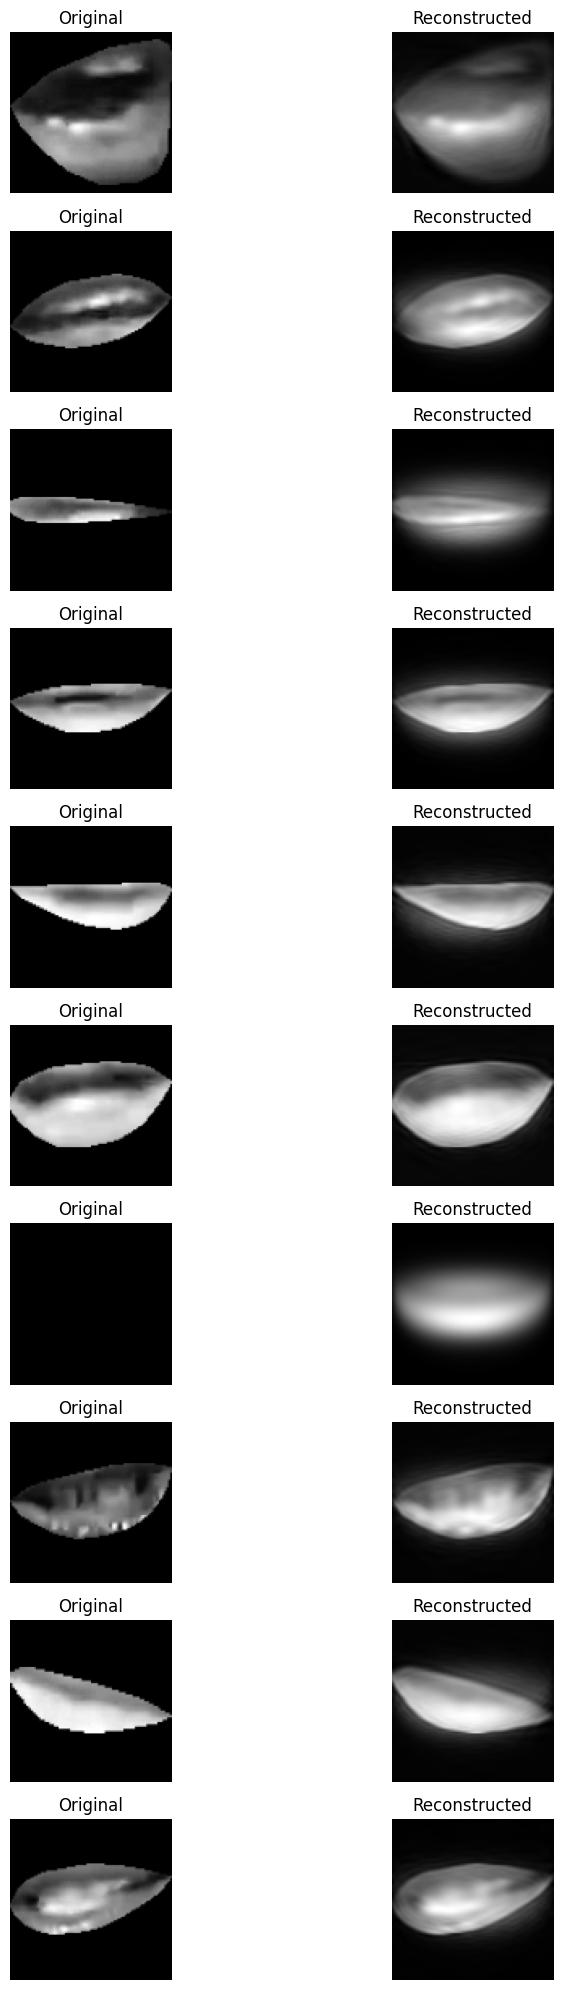

In [ ]:
import os
import cv2
import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

def load_and_flatten_images_in_chunks(image_dir, target_size=(100, 100), chunk_size=100):
    filenames = [f for f in os.listdir(image_dir)[lower_idx:upper_idx] if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    for i in range(0, len(filenames), chunk_size):
        chunk_filenames = filenames[i:i + chunk_size]
        chunk = []
        for filename in chunk_filenames:
            img_path = os.path.join(image_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Failed to load {img_path}")
                continue
            resized_image = cv2.resize(image, target_size)
            chunk.append(resized_image.flatten())
        yield np.array(chunk)

def incremental_pca(image_dir, n_components=50, chunk_size=100, target_size=(100, 100)):
    ipca = IncrementalPCA(n_components=n_components)
    mean_image = None
    n_samples = 0

    # Calculate mean image incrementally
    for chunk in tqdm(load_and_flatten_images_in_chunks(image_dir, target_size, chunk_size), desc="Calculating Mean"):
        if mean_image is None:
            mean_image = np.zeros_like(chunk[0], dtype=np.float64)  # Ensure floating-point precision
        mean_image += np.sum(chunk, axis=0)
        n_samples += chunk.shape[0]
    mean_image /= n_samples  # Average over all samples

    # Fit Incremental PCA incrementally
    for chunk in tqdm(load_and_flatten_images_in_chunks(image_dir, target_size, chunk_size), desc="Fitting PCA"):
        ipca.partial_fit(chunk - mean_image)

    return ipca, mean_image


def save_pca(ipca, mean_image, output_dir, n_components):
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, f"incremental_pca_{n_components}.pkl"), 'wb') as f:
        pickle.dump(ipca, f)
    np.save(os.path.join(output_dir, f"mean_image_{n_components}.npy"), mean_image)

def load_pca(output_dir, n_components):
    with open(os.path.join(output_dir, f"incremental_pca_{n_components}.pkl"), 'rb') as f:
        ipca = pickle.load(f)
    mean_image = np.load(os.path.join(output_dir, "mean_image.npy"))
    return ipca, mean_image

def plot_original_vs_reconstructed(flattened_images, ipca, mean_image, target_size, n_sub_img=10, step=5):
    reconstructed_images = ipca.inverse_transform(ipca.transform(flattened_images)) + mean_image
    for j in range(step):
        fig, axes = plt.subplots(n_sub_img, 2, figsize=(10, n_sub_img * 2))
        for i in range(n_sub_img):
            idx = j * step + i
            if idx >= len(flattened_images):
                break
            original = flattened_images[idx].reshape(target_size)
            reconstructed = reconstructed_images[idx].reshape(target_size)

            axes[i, 0].imshow(original, cmap='gray')
            axes[i, 0].axis('off')
            axes[i, 0].set_title('Original')

            axes[i, 1].imshow(reconstructed, cmap='gray')
            axes[i, 1].axis('off')
            axes[i, 1].set_title('Reconstructed')

        plt.tight_layout()
        plt.show()

# Main script
image_directory = "vox_frames"
output_dir = "pca"
n_components = 500
chunk_size = 1000

# Step 1: Perform Incremental PCA
ipca, mean_image = incremental_pca(image_directory, n_components, chunk_size)

# Step 2: Save Incremental PCA properties
save_pca(ipca, mean_image, output_dir, n_components)
print("Incremental PCA model and mean image saved.")

# Step 3: Load Incremental PCA properties
ipca_loaded, mean_image_loaded = load_pca(output_dir, n_components)
print("Incremental PCA model and mean image loaded.")

# Step 4: Plot original vs reconstructed images
flattened_images = next(load_and_flatten_images_in_chunks(image_directory, chunk_size=chunk_size))
plot_original_vs_reconstructed(flattened_images, ipca_loaded, mean_image_loaded, target_size=(100, 100))


In [ ]:
image_directory = "vox_frames"
output_dir = "pca"
n_components = 216
chunk_size = 1000

# Step 1: Perform Incremental PCA
ipca, mean_image = incremental_pca(image_directory, n_components, chunk_size)

# Step 2: Save Incremental PCA properties
save_pca(ipca, mean_image, output_dir, n_components)
print("Incremental PCA model and mean image saved.")

# Step 3: Load Incremental PCA properties
ipca_loaded, mean_image_loaded = load_pca(output_dir, n_components)

Calculating Mean: 72it [00:17,  4.22it/s]
Fitting PCA: 72it [41:29, 34.57s/it]

Incremental PCA model and mean image saved.


In [ ]:
!pwd

/content


In [ ]:
!zip -r pca.zip pca


  adding: pca/ (stored 0%)
  adding: pca/incremental_pca_500.pkl (deflated 6%)
  adding: pca/mean_image_1_500.npy (deflated 63%)
  adding: pca/incremental_pca_216.pkl (deflated 7%)
  adding: pca/pca_model_1_500.pkl (deflated 10%)
  adding: pca/mean_image.npy (deflated 45%)


In [ ]:
%cd /content
# !gdown "https://drive.google.com/uc?id=#######################################333"
# https://drive.google.com/file/d/#######################################333/view?usp=sharing



#pip install google-api-python-client
from googleapiclient.discovery import build
from google.oauth2 import service_account

SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = 'avss8.json'
PARENT_FOLDER_ID = ""

def authenticate():
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    drive_service = build('drive', 'v3', credentials=creds)
    about = drive_service.about().get(fields="storageQuota").execute()
    print(about)
    return creds


def upload_zip(file_path, name):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)

    file_metadata = {
        'name' : f"{name}.zip",
        'parents' : ["1inmcdEFAFFHn6_bDnuRR6KEYXFeYOsMZ"]
    }

    file = service.files().create(
        body=file_metadata,
        media_body=file_path
    ).execute()

upload_zip(f"pca.zip", f"pca_{instance_idx}")
print(f"vs")

/content


{'storageQuota': {'limit': '16106127360', 'usage': '13290114503', 'usageInDrive': '13290114503', 'usageInDriveTrash': '0'}}
vs
